In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sentencepiece as spm
import torch as th

In [5]:
cif_seg = [ 0.0000,  0.1429,  0.7755,  1.0408,  1.2449,  1.4898,  1.6939,  3.0612,
         3.2449,  3.5510,  4.6735,  5.1020,  5.3673,  5.6122,  6.4082,  7.1837,
         8.3469,  9.6735, 10.9592, 12.1837, 12.4490, 12.9184, 13.1633, 13.4286,
        13.6939, 13.8776]

In [22]:
cif_without_align_seg = [ 0.0000,  0.4694,  0.6327,  0.8980,  1.0204,  1.1633,  1.3878,  1.5102,
         3.0612,  3.2041,  3.6122,  4.9184,  5.1020,  5.2041,  5.4490,  5.7347,
        11.7551, 12.2653, 12.3878, 12.5918, 12.8980, 13.0816, 13.2245, 13.4490,
        13.6735, 13.8776]

In [29]:
real_seg = [0., 0.2, 0.3, 0.55, 0.73, 1.06, 1.19, 1.81, 3.36, 3.92, 5.04, 5.31, 5.64, 11.98, 12.10, 12.6, 
            12.82, 13.08, 13.62]

<StemContainer object of 3 artists>

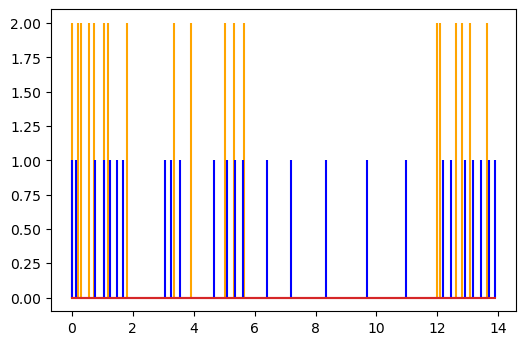

In [30]:
plt.figure(dpi=100)
plt.stem(real_seg, np.ones_like(real_seg) * 2, markerfmt='none', linefmt='orange')
plt.stem(cif_seg, np.ones_like(cif_seg), markerfmt='none', linefmt='blue')

<StemContainer object of 3 artists>

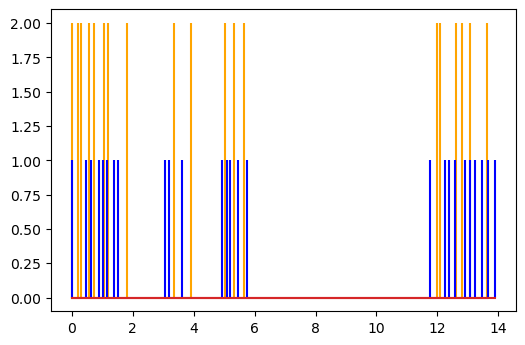

In [31]:
plt.figure(dpi=100)
plt.stem(real_seg, np.ones_like(real_seg) * 2, markerfmt='none', linefmt='orange')
plt.stem(cif_without_align_seg, np.ones_like(cif_without_align_seg), markerfmt='none', linefmt='blue')

In [16]:
bpe = spm.SentencePieceProcessor()
bpe.Load('/home/ubuntu/work/datasets/must-c/en-de/spm_unigram10000_wave_joint.model')

True

In [21]:
print(bpe.EncodeAsPieces("And I say that sincerely, partly because (Mock sob) I need that. (Laughter) put yourself in my position" ))

['▁And', '▁I', '▁say', '▁that', '▁since', 're', 'ly', ',', '▁part', 'ly', '▁because', '▁', '(', 'M', 'ock', '▁so', 'b', ')', '▁I', '▁need', '▁that', '.', '▁', '(', 'L', 'a', 'ught', 'er', ')', '▁put', '▁yourself', '▁in', '▁my', '▁position']


In [58]:
ids = bpe.EncodeAsIds("And I say that sincerely, partly because (Mock sob) I need that. (Laughter)")

In [33]:
st_feature = th.load('/home/ubuntu/work/experiments/tmp/st_feature.pt')

In [35]:
model = th.load('/home/ubuntu/work/experiments/checkpoints/st-pretrained-noalign/checkpoint_best.pt')

In [39]:
model['model'].keys()

odict_keys(['encoder.w2v_model.mask_emb', 'encoder.w2v_model.feature_extractor.conv_layers.0.0.weight', 'encoder.w2v_model.feature_extractor.conv_layers.0.2.weight', 'encoder.w2v_model.feature_extractor.conv_layers.0.2.bias', 'encoder.w2v_model.feature_extractor.conv_layers.1.0.weight', 'encoder.w2v_model.feature_extractor.conv_layers.2.0.weight', 'encoder.w2v_model.feature_extractor.conv_layers.3.0.weight', 'encoder.w2v_model.feature_extractor.conv_layers.4.0.weight', 'encoder.w2v_model.feature_extractor.conv_layers.5.0.weight', 'encoder.w2v_model.feature_extractor.conv_layers.6.0.weight', 'encoder.w2v_model.post_extract_proj.weight', 'encoder.w2v_model.post_extract_proj.bias', 'encoder.w2v_model.quantizer.vars', 'encoder.w2v_model.quantizer.weight_proj.weight', 'encoder.w2v_model.quantizer.weight_proj.bias', 'encoder.w2v_model.project_q.weight', 'encoder.w2v_model.project_q.bias', 'encoder.w2v_model.encoder.pos_conv.0.bias', 'encoder.w2v_model.encoder.pos_conv.0.weight_g', 'encoder.w

In [41]:
embedding = model['model']['encoder.text_embedding.weight']

In [42]:
embedding.size()

torch.Size([10000, 256])

In [59]:
text_embeddings = embedding[ids, :]

In [62]:
st_feature.size(0), text_embeddings.size(0)

(26, 29)

In [60]:
pairwise_dist = th.zeros(st_feature.size(0), text_embeddings.size(0)).to('cuda')
for i in range(st_feature.size(0)):
    for j in range(text_embeddings.size(0)):
        pairwise_dist[i, j] = th.norm(st_feature[i] - text_embeddings[j])

In [64]:
print(pairwise_dist.diag().mean())

tensor(15.2085, device='cuda:0') tensor(15.6474, device='cuda:0')


In [54]:
pairwise_cosdist = th.zeros(st_feature.size(0), text_embeddings.size(0)).to('cuda')
for i in range(st_feature.size(0)):
    for j in range(text_embeddings.size(0)):
        pairwise_cosdist[i, j] = (st_feature[i] * text_embeddings[j]).sum() / st_feature[i].norm() / text_embeddings[j].norm()

In [66]:
print(pairwise_cosdist.diag().mean(), pairwise_cosdist.mean())

tensor(-0.0390, device='cuda:0') tensor(-0.0872, device='cuda:0')
